In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

## Load the data

In [2]:
df = pd.read_csv('../cleaned_data/EXCL.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,3.059533,3.007273,2.938809,1.053684,1.761675,1.705354,1.715120,0.324503,0.722584,0.996105,0.008923,1.34241,1.016593,-1.845348,1.033444,0.147246,1.030312,3.395286
2012-10-18,3.111350,3.046031,2.964583,1.915311,1.761675,1.705354,1.715120,0.787275,0.583963,0.928232,0.716706,1.34241,1.016593,-1.845348,1.042927,0.261864,1.030312,3.395286
2012-10-19,3.176120,3.081559,2.988210,1.970523,1.998807,1.924055,1.909460,1.382241,0.657416,0.968922,1.424489,1.34241,1.016593,-1.845348,1.052410,0.376483,1.030312,3.486288
2012-10-22,3.253845,3.120318,3.016132,1.767559,0.597816,1.020966,1.207254,-0.102020,-0.091455,0.026726,-1.406643,1.34241,1.016593,-1.845348,1.080859,0.720337,1.096678,3.304284
2012-10-23,3.299184,3.149386,3.035463,0.647818,0.093460,0.636550,0.891438,-0.494746,-0.343995,0.057185,-0.698860,1.34241,1.016593,-1.845348,1.090342,0.834955,1.096678,3.213282


### Plot the Close price - our target

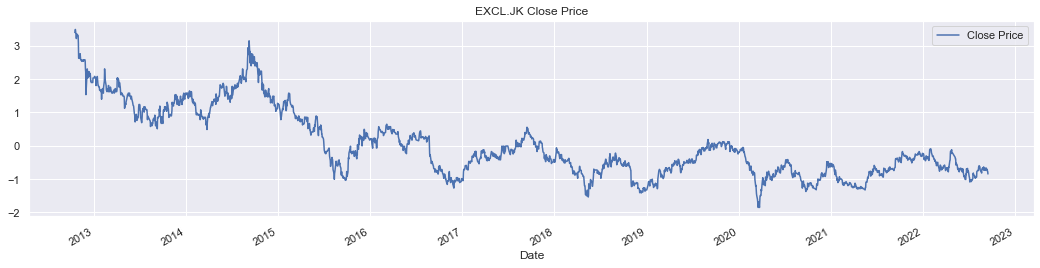

In [3]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('EXCL.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [4]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Understanding Time Series Data

### Decompose time series into Trend, Seasonality, and Random Noise

In [6]:
import statsmodels.api as sm

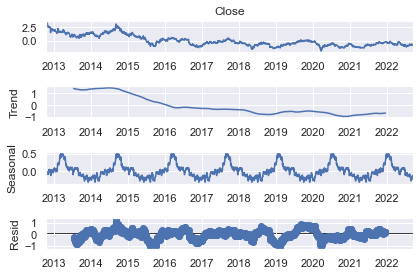

In [24]:
seas_d = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
fig = seas_d.plot()
plt.show()

### ADF Test to check stationarity of the data

In [12]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [13]:
test_adf(df['Close'], 'Stock Close Price')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Close Price


In [16]:
# """
# The Close price is not stationary. 
# Therefore, differencing needs to be performed
# """
# test_adf(df['Close'].diff(), 'Stock Close Price - First Difference')

### Plot ACF (Autocorrelation) and PACF (Partial Autocorrelation)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


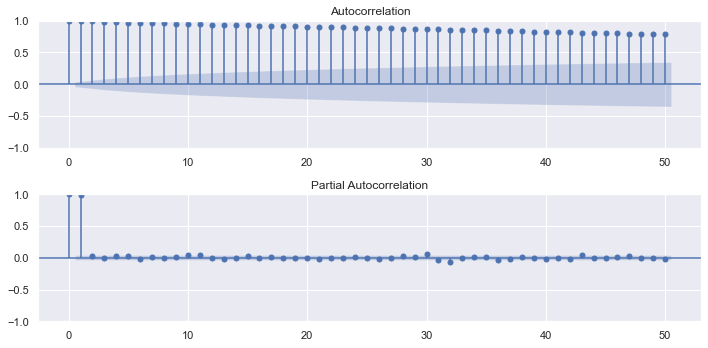

In [18]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

fig = sm.tsa.graphics.plot_acf(df['Close'], lags=50, ax=ax[0])

fig = sm.tsa.graphics.plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

## Build the SARIMAX model

### Use auto_arima to determine the optimal p,d,q orders
We can determine p,d,q orders by using ACF and PACF plots above. However, a stepwise search will enable us to try out more optimal p,d,q orders.

In [19]:
from pmdarima.arima import auto_arima

In [50]:
step_wise_exog = auto_arima(train_labels, exogenous= train_features,
                           start_p=0, start_q=0, 
                           max_p=7, max_q=7, 
                           d=None, D=1, test='adf', max_d=7, seasonal=True, m=5,
                           trace=True, 
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[5] intercept   : AIC=-973.502, Time=1.33 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=-960.171, Time=0.35 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=-3193.443, Time=1.20 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=-2162.269, Time=1.01 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=-955.211, Time=0.18 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=-2715.507, Time=0.26 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=-3401.444, Time=2.08 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=4.54 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=-973.604, Time=1.32 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=-3401.509, Time=3.39 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=-3195.920, Time=1.78 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=6.30 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=-3401

In [51]:
step_wise_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1967
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 5)   Log Likelihood                1707.056
Date:                           Wed, 23 Nov 2022   AIC                          -3402.113
Time:                                   00:18:01   BIC                          -3368.623
Sample:                                        0   HQIC                         -3389.804
                                          - 1967                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9178      0.017     54.709      0.000       0.885       0.951
ar.L2         -0.0027      0.023     -0.118      0.906      -0.048       0.043
ar.L3         -0.0324      0.018     -1.795      0.073      -0.068       0.003
ar.S.L5       -0.6458      0.020    -31.973      0.000      -0.685      -0.606
ar.S.L10      -0.3261      0.020    -16.452      0.000      -0.365      -0.287
sigma2         0.0103      0.000     48.759      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               772.39
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

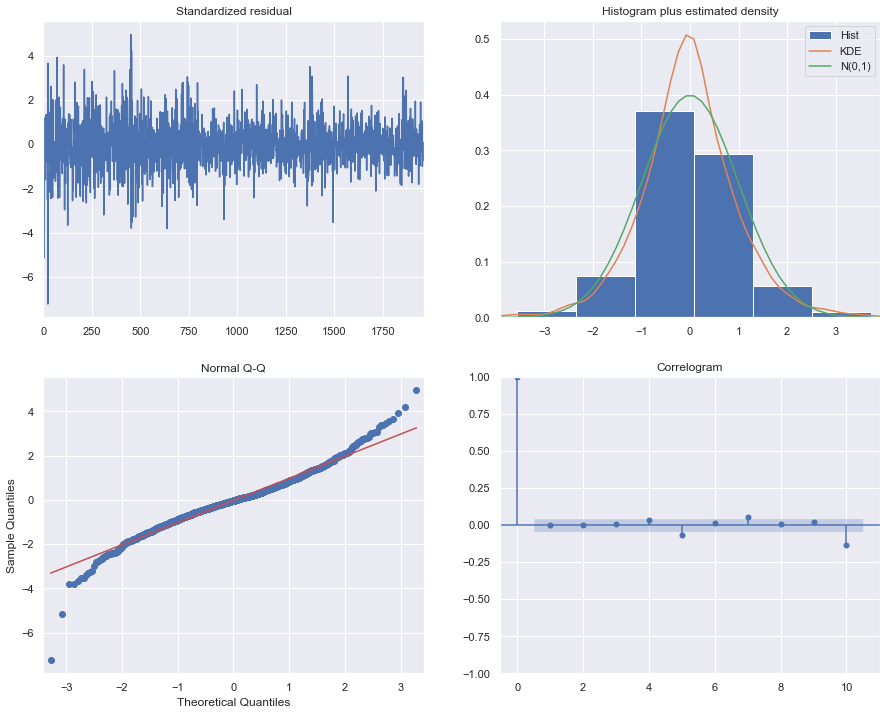

In [52]:
step_wise_exog.plot_diagnostics(figsize=(15,12));

### Fit the SARIMAX model using the best p,d,q orders

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [54]:
model_exog = SARIMAX(train_labels, exog=train_features,
                order=(3,0,0), seasonal_order=(2,1,0,5),
                enforce_invertibility=True, enforce_stationarity=True)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [55]:
results = model_exog.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [56]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 5)   Log Likelihood                4012.036
Date:                           Wed, 23 Nov 2022   AIC                          -7978.073
Time:                                   00:18:56   BIC                          -7849.693
Sample:                                        0   HQIC                         -7930.889
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.0532      0.023      2.267      0.023       0.007       0.099
14 DAYS MA         0.0293      0.045      0.646      0.518      -0.060       0.118
21 DAYS MA         0.3917      0.048      8.236      0.000       0.299       0.485
7 DAYS STD DEV     0.0007      0.001      0.604      0.546      -0.001       0.003
RSI 7              0.0783      0.010      7.827      0.000       0.059       0.098
RSI 14            -0.5526      0.038    -14.570      0.000      -0.627      -0.478
RSI 21             0.7925      0.031     25.640      0.000       0.732       0.853
MFI 7              0.0023      0.002      1.348      0.178      -0.001       0.006
MFI 14             0.0002      0.002      0.111      0.911      -0.004       0.004
MFI 21            -0.0058      0.002     -2.482      0.013      -0.010      -0.001
dayofweek         -0.0004      0.001     -0.337      0.736      -0.002       0.002
quarter           -0.0179      0.008     -2.137      0.033      -0.034      -0.001
month             -0.0791      0.334     -0.237      0.813      -0.734       0.576
year              -0.5027      0.357     -1.408      0.159      -1.203       0.197
dayofyear          0.0452      0.336      0.135      0.893      -0.613       0.703
dayofmonth        -0.0082      0.028     -0.297      0.766      -0.063       0.046
weekofyear        -0.0014      0.004     -0.378      0.706      -0.009       0.006
ar.L1              0.7310      0.017     43.046      0.000       0.698       0.764
ar.L2              0.0595      0.020      2.933      0.003       0.020       0.099
ar.L3              0.0632      0.016      4.072      0.000       0.033       0.094
ar.S.L5           -0.6741      0.018    -37.778      0.000      -0.709      -0.639
ar.S.L10          -0.2828      0.019    -15.227      0.000      -0.319      -0.246
sigma2             0.0010   2.01e-05     48.821      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  77.17   Jarque-Bera (JB):              6247.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [57]:
predictions = results.predict(start=train_len, end=len(df)-1, exog=test_features)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [58]:
actual_close = df[['Close']]
act = pd.DataFrame(actual_close.iloc[train_len:, 0])

In [59]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_features.index
predictions['Actual'] = act['Close']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [60]:
predictions

,Pred,Actual
Date,,
2020-09-10,-1.292041,-1.274796
2020-09-11,-1.107295,-1.136410
2020-09-14,-1.005561,-1.062604
2020-09-15,-1.077494,-1.127184
2020-09-16,-1.147069,-1.191764
...,...,...
2022-09-12,-0.826722,-0.721252
2022-09-13,-0.816401,-0.712026
2022-09-14,-0.901907,-0.767380


<AxesSubplot:xlabel='Date'>

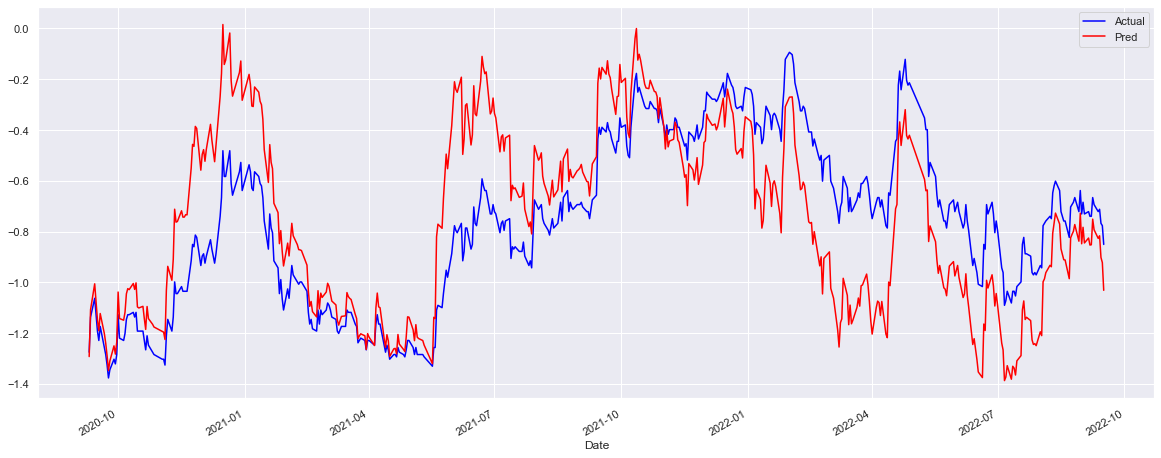

In [61]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Evaluation

In [62]:
from joblib import load

In [63]:
close_scaler = load('../feature_engineering/excl_close_scaler.bin')

In [64]:
inversed_pred = close_scaler.inverse_transform(np.array(predictions['Pred']).reshape(-1,1))
inversed_act = close_scaler.inverse_transform(np.array(predictions['Actual']).reshape(-1,1))

In [65]:
inversed = pd.DataFrame(inversed_pred)
inversed['Actual'] = inversed_act
inversed.rename({0:'Pred'}, axis=1, inplace=True)
inversed.index = test_labels.index
inversed.head(2)

,Pred,Actual
Date,,
2020-09-10,2021.307314,2040.0
2020-09-11,2221.558513,2190.0


**Plot Error Distribution**

In [66]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

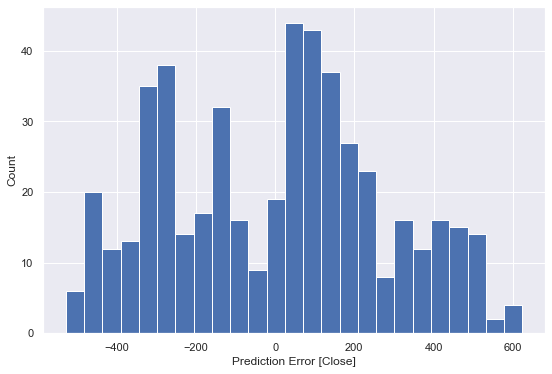

In [67]:
plt.figure(figsize=(9,6))
plotErrorHist(inversed)

**RMSE**

In [68]:
from statsmodels.tools.eval_measures import rmse

In [69]:
rmse(inversed['Pred'], inversed['Actual'])

275.3961296939142

**MAPE**

In [70]:
# mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [71]:
mape(inversed['Actual'], inversed['Pred'])

8.878754721180321

**R-squared**

In [72]:
from sklearn.metrics import r2_score

In [73]:
r2_score(inversed['Actual'], inversed['Pred'])

0.37093968952551837

### Save the model

In [74]:
from joblib import dump, load
dump(results, './models/excl.joblib') 

['./models/excl.joblib']

In [75]:
loaded = load('./models/excl.joblib')
loaded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 5)   Log Likelihood                4012.036
Date:                           Wed, 23 Nov 2022   AIC                          -7978.073
Time:                                   00:19:27   BIC                          -7849.693
Sample:                                        0   HQIC                         -7930.889
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.0532      0.023      2.267      0.023       0.007       0.099
14 DAYS MA         0.0293      0.045      0.646      0.518      -0.060       0.118
21 DAYS MA         0.3917      0.048      8.236      0.000       0.299       0.485
7 DAYS STD DEV     0.0007      0.001      0.604      0.546      -0.001       0.003
RSI 7              0.0783      0.010      7.827      0.000       0.059       0.098
RSI 14            -0.5526      0.038    -14.570      0.000      -0.627      -0.478
RSI 21             0.7925      0.031     25.640      0.000       0.732       0.853
MFI 7              0.0023      0.002      1.348      0.178      -0.001       0.006
MFI 14             0.0002      0.002      0.111      0.911      -0.004       0.004
MFI 21            -0.0058      0.002     -2.482      0.013      -0.010      -0.001
dayofweek         -0.0004      0.001     -0.337      0.736      -0.002       0.002
quarter           -0.0179      0.008     -2.137      0.033      -0.034      -0.001
month             -0.0791      0.334     -0.237      0.813      -0.734       0.576
year              -0.5027      0.357     -1.408      0.159      -1.203       0.197
dayofyear          0.0452      0.336      0.135      0.893      -0.613       0.703
dayofmonth        -0.0082      0.028     -0.297      0.766      -0.063       0.046
weekofyear        -0.0014      0.004     -0.378      0.706      -0.009       0.006
ar.L1              0.7310      0.017     43.046      0.000       0.698       0.764
ar.L2              0.0595      0.020      2.933      0.003       0.020       0.099
ar.L3              0.0632      0.016      4.072      0.000       0.033       0.094
ar.S.L5           -0.6741      0.018    -37.778      0.000      -0.709      -0.639
ar.S.L10          -0.2828      0.019    -15.227      0.000      -0.319      -0.246
sigma2             0.0010   2.01e-05     48.821      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  77.17   Jarque-Bera (JB):              6247.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""